In [1]:
# Import code and data.

import gc   # For manual garbage collection.
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from numba import njit

experiment = 'Exp1'

# Import and select data.
all_data = pd.read_csv('total_data_github.csv',
    usecols = ['gps.lat', 'gps.lon', 'altitudeRelative', 'Concentration', 'Experiment'],
)
all_data = all_data[all_data['Experiment'] == experiment]
all_data = all_data.drop(columns = ['Experiment'])

# Import and select metadata.
data_summary = pd.read_csv('data_summary_github.csv',
    usecols = ['Experiment', 'Wind_Dir', 'WindSpeed', 'boat.lat', 'boat.lon']
)
data_summary = data_summary[data_summary['Experiment'] == experiment]
wind_dir = data_summary['Wind_Dir'].values[0]
wind_speed = data_summary['WindSpeed'].values[0]

# Convert lat and lon to distances from boat in downwind and crosswind directions.
all_data['dist_lat'] = (all_data['gps.lat'] - data_summary['boat.lat'].values[0]) * 111000
all_data['dist_lon'] = (all_data['gps.lon'] - data_summary['boat.lon'].values[0]) * 111000
all_data['x'] = all_data['dist_lon'] * np.cos(270 - wind_dir) + all_data['dist_lat'] * np.sin(270 - wind_dir)
all_data['y'] = all_data['dist_lon'] * np.cos(360 - wind_dir) + all_data['dist_lat'] * np.sin(360 - wind_dir)
all_data['z'] = all_data['altitudeRelative']

# Modify concentrations.
all_data['Concentration'] = all_data['Concentration'] * 0.01 ** 3

# Split data, 80% for training and 20% for testing, shuffling rows first.
all_data = all_data.drop(columns = ['altitudeRelative', 'dist_lat', 'dist_lon', 'gps.lat', 'gps.lon'])
all_data = np.asarray(all_data)   # Prepare for Numba.
np.random.seed(1)                 # Ensure the same split each time.
np.random.shuffle(all_data)
training_data, testing_data = np.split(all_data, [int(0.8 * len(all_data))])

# Release unused memory.
del(all_data)
del(data_summary)
del(experiment)
del(wind_dir)
gc.collect()

0

In [2]:
# Model parameter and functions setup.

# Inference and model parameters.
H = np.float64(0.0)
# k_a = 0.33
# k_b = 0.86
# k_Q = 1.1e-3
k_0 = np.array([0.33, 0.86, 1.1e-3])
# theta_a = 1.0
# theta_b = 1.0
# theta_Q = 1e-3
theta_0 = np.array([1.0, 1.0, 1e-3])


################################################################################

# Non-jitted functions.

# Function for calculating the conditional probability for parameters a, b or Q.
def log_cond_prob_abQ(abQ, j, theta, log_lhood):
    return np.log(abQ) * j - abQ / theta + log_lhood


# MCMC Sampler for a, b or Q.
def sample_abQ(current_abQ, j, theta, ss, precalc2):

    # Set current and proposed values for a, b or Q.
    # np.random.normal generates random numbers from a normal distribution.
    proposed_abQ = np.random.normal(loc = current_abQ, scale = ss)

    # Though an sotensibly unnecessary variable declaration (the logic can be added directly inside the np.exp call below),
    # it's needed for correct Numba execution.
    log_p_prop_abQ = log_cond_prob_abQ(proposed_abQ, j, theta, precalc2)

    # Acceptance criteria.
    # Calculate the conditional probability of current and proposed a, b or Q.
    # N.B. Using parameter names in "uniform" breaks Numba.
    if np.random.uniform(0.0, 1.0) < np.exp(log_p_prop_abQ - log_cond_prob_abQ(current_abQ, j, theta, precalc2)):
        return proposed_abQ
    else:
        return current_abQ


# Full MCMC sampler.
def sample_process(N_samples, ss, u, H, data, sigma, abQ_init, theta_array):

    np.random.seed(117)   # Seed the Numba rng.

    # Intialisation.
    # - Pre-allocate memory space for data where relevant.
    # - Variables declared in order of largest to smallest.
    negysqr = -data[:,2]**2            # Column 2 holds "y" values.
    zdownsqr = -(data[:,3] - H)**2     # Column 3 holds "z" values.
    zupsqr = -(data[:,3] + H)**2
    #
    abQ_means = np.empty((N_samples, len(abQ_init)), np.float64)    # rows = N_samples, cols = len(abQ_init). Use rounded brackets, not square, for "empty" in Numba.
    abQ_means[:] = np.NaN
    abQ_samples = abQ_means.copy()
    abQ = abQ_init.copy()
    #
    abQ_init = 1 - abQ_init
    #
    piu = np.pi * u                    # Saved as np.float64.
    sigma = np.float64(2 * sigma**2)   # Saved as np.float64.
    count = 0                          # Saved as integer.

    for j in range(N_samples):

        count = count + 1
        if (count % 10000 == 0):
            print('Running sample ' + str(count) + '...')    # Print progress every 10,000th sample.

        # Column 1 holds "x" values.
        precalc1 = 2 * abQ[0] * data[:,1] ** abQ[1]
        # Column 0 holds "Concentration" values.
        precalc2 = -sum((abQ[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2 / sigma)

        abQ[0] = sample_abQ(abQ[0], abQ_init[0], theta_array[0], ss[0], precalc2)   # a
        abQ[1] = sample_abQ(abQ[1], abQ_init[1], theta_array[1], ss[1], precalc2)   # b
        abQ[2] = sample_abQ(abQ[2], abQ_init[2], theta_array[2], ss[2], precalc2)   # Q
        abQ_samples[j] = abQ
        #abQ_means[j] = np.mean(abQ_samples[:count, :], axis = 0)   # Numba doesn't support an axis argument for "mean".
        abQ_means[j, 0] = np.mean(abQ_samples[:count, 0:1])
        abQ_means[j, 1] = np.mean(abQ_samples[:count, 1:2])
        abQ_means[j, 2] = np.mean(abQ_samples[:count, 2:3])

    print('Sampling complete.')
    return abQ_samples, abQ_means


################################################################################

# Jitted versions of the sampling functions.

# Function for calculating the conditional probability for parameters a, b or Q.
@njit(nogil=True)
def log_cond_prob_abQ_jit(abQ, j, theta, log_lhood):
    return np.log(abQ) * j - abQ / theta + log_lhood


# MCMC Sampler for a, b or Q.
@njit(nogil=True)
def sample_abQ_jit(current_abQ, j, theta, ss, precalc2):

    # Set current and proposed values for a, b or Q.
    # np.random.normal generates random numbers from a normal distribution.
    proposed_abQ = np.random.normal(loc = current_abQ, scale = ss)

    # Though an sotensibly unnecessary variable declaration (the logic can be added directly inside the np.exp call below),
    # it's needed for correct Numba execution.
    log_p_prop_abQ = log_cond_prob_abQ_jit(proposed_abQ, j, theta, precalc2)

    # Acceptance criteria.
    # Calculate the conditional probability of current and proposed a, b or Q.
    # N.B. Using parameter names in "uniform" breaks Numba.
    if np.random.uniform(0.0, 1.0) < np.exp(log_p_prop_abQ - log_cond_prob_abQ_jit(current_abQ, j, theta, precalc2)):
        return proposed_abQ
    else:
        return current_abQ


# Full MCMC sampler.
@njit(nogil=True)
def sample_process_jit(N_samples, ss, u, H, data, sigma, abQ_init, theta_array):

    np.random.seed(117)   # Seed the Numba rng.

    # Intialisation.
    # - Pre-allocate memory space for data where relevant.
    # - Variables declared in order of largest to smallest.
    negysqr = -data[:,2]**2            # Column 2 holds "y" values.
    zdownsqr = -(data[:,3] - H)**2     # Column 3 holds "z" values.
    zupsqr = -(data[:,3] + H)**2
    #
    abQ_means = np.empty((N_samples, len(abQ_init)), np.float64)    # rows = N_samples, cols = len(abQ_init). Use rounded brackets, not square, for "empty" in Numba.
    abQ_means[:] = np.NaN
    abQ_samples = abQ_means.copy()
    abQ = abQ_init.copy()
    #
    abQ_init = 1 - abQ_init
    #
    piu = np.pi * u                    # Saved as np.float64.
    sigma = np.float64(2 * sigma**2)   # Saved as np.float64.
    count = 0                          # Saved as integer.

    for j in range(N_samples):

        count = count + 1
        if (count % 10000 == 0):
            print('Running sample ' + str(count) + '...')    # Print progress every 10,000th sample.

        # Column 1 holds "x" values.
        precalc1 = 2 * abQ[0] * data[:,1] ** abQ[1]
        # Column 0 holds "Concentration" values.
        precalc2 = -sum((abQ[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2 / sigma)

        abQ[0] = sample_abQ_jit(abQ[0], abQ_init[0], theta_array[0], ss[0], precalc2)   # a
        abQ[1] = sample_abQ_jit(abQ[1], abQ_init[1], theta_array[1], ss[1], precalc2)   # b
        abQ[2] = sample_abQ_jit(abQ[2], abQ_init[2], theta_array[2], ss[2], precalc2)   # Q

        abQ_samples[j] = abQ
        #abQ_means[j] = np.mean(abQ_samples[:count, :], axis = 0)   # Numba doesn't support an axis argument for "mean".
        abQ_means[j, 0] = np.mean(abQ_samples[:count, 0:1])
        abQ_means[j, 1] = np.mean(abQ_samples[:count, 1:2])
        abQ_means[j, 2] = np.mean(abQ_samples[:count, 2:3])

    print('Sampling complete.')
    return abQ_samples, abQ_means


################################################################################

# Utility functions.

# Gaussian Plume Model for concentration.
def C_func(x, y, z, u, a, b, Q, H):
    tmp = 2*a*x**b
    C = Q / (tmp * np.pi*u) * (np.exp(-(y**2) / tmp)) * (np.exp(-(z-H)**2 / tmp) + np.exp(-(z+H)**2 / tmp))
    return C


# Sampling traceplots.
def traceplots(x, xnames = None, title = None):

    d = x.shape[1]
    fig = plt.figure()
    left, tracewidth, histwidth = 0.1, 0.65, 0.15
    bottom, rowheight = 0.1, 0.8/d

    for i in range(d):
        # Set the location of the trace and histogram viewports,
        # starting with the first dimension from the bottom of the canvas.
        rowbottom = bottom + i * rowheight
        rect_trace = (left, rowbottom, tracewidth, rowheight)
        rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)

        # First set of trace plot axes.
        if i == 0:
            ax_trace = fig.add_axes(rect_trace)
            ax_trace.plot(x[:,i])
            ax_trace.set_xlabel("Sample Count")
            ax_tr0 = ax_trace

        # Other sets of trace plot axes that share the first trace's x-axis.
        # Make tick labels invisible so they don't clutter up the plot.
        elif i > 0:
            ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
            ax_trace.plot(x[:,i])
            plt.setp(ax_trace.get_xticklabels(), visible=False)

        # Title at the top.
        if i == d-1 and title is not None:
            plt.title(title)

        # Trace y-axis labels.
        if xnames is not None:
            ax_trace.set_ylabel(xnames[i])

        # Trace histograms at the right.
        ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
        ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
        plt.setp(ax_hist.get_xticklabels(), visible=False)
        plt.setp(ax_hist.get_yticklabels(), visible=False)
        xlim = ax_hist.get_xlim()
        ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])


In [3]:
# Sampling, unjitted.
# Default samples: 100000.
for i in range(0, 200):
    time_start = datetime.now()
    abQ_samples, abQ_means = sample_process(N_samples = 10000, ss = np.array([0.1, 0.1, 1e-4]), u = wind_speed, H = H, data = training_data,
                                            sigma = 0.1, abQ_init = k_0.copy(), theta_array = theta_0)
    # Display execution time.
    print(f"Execution time was: {(datetime.now() - time_start).total_seconds():.02f}s")



C:\Users\ARCUser\AppData\Local\Temp\ipykernel_5532\4190267017.py:21: RuntimeWarning: invalid value encountered in log
  return np.log(abQ) * j - abQ / theta + log_lhood


Running sample 10000...
Sampling complete.
Execution time was: 10.20s


In [4]:
# Sampling, jitted.

# Numpy warmup run. Retain to invoke compilation.
time_start = datetime.now()
abQ_samples_jit, abQ_means_jit = sample_process_jit(N_samples = 1, ss = np.array([0.1, 0.1, 1e-4]), u = wind_speed, H = H, data = training_data,
                                                    sigma = 0.1, abQ_init = k_0.copy(), theta_array = theta_0)
abQ_samples_jit, abQ_means_jit = sample_process_jit(N_samples = 10000, ss = np.array([0.1, 0.1, 1e-4]), u = wind_speed, H = H, data = training_data,
                                                    sigma = 0.1, abQ_init = k_0.copy(), theta_array = theta_0)
# Display execution time.
print(f"Execution time was: {(datetime.now() - time_start).total_seconds():.02f}s")


# Sampling proper.
# Default samples: 100000.
for i in range(0, 199):
    time_start = datetime.now()
    abQ_samples_jit, abQ_means_jit = sample_process_jit(N_samples = 10000, ss = np.array([0.1, 0.1, 1e-4]), u = wind_speed, H = H, data = training_data,
                                                        sigma = 0.1, abQ_init = k_0.copy(), theta_array = theta_0)
    # Display execution time.
    print(f"Execution time was: {(datetime.now() - time_start).total_seconds():.02f}s")

# Multithreaded execution.
#import concurrent.futures
#with concurrent.futures.ThreadPoolExecutor() as executor:
#    for x in range(6):
#        executor.submit(sample_process_jit, N_samples = 100000, ss = np.array([0.1, 0.1, 1e-4]), u = wind_speed, H = H, data = training_data,
#                                            sigma = 0.1, abQ_init = k_0.copy(), theta_array = theta_0)


Sampling complete.
Running sample 10000...
Sampling complete.
Execution time was: 8.04s
Running sample 10000...
Sampling complete.
Execution time was: 5.30s


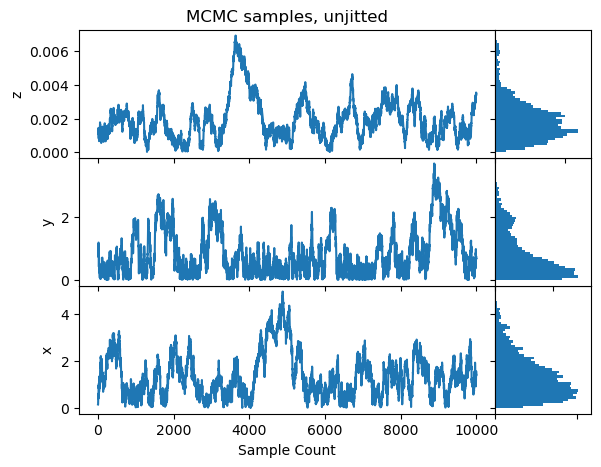

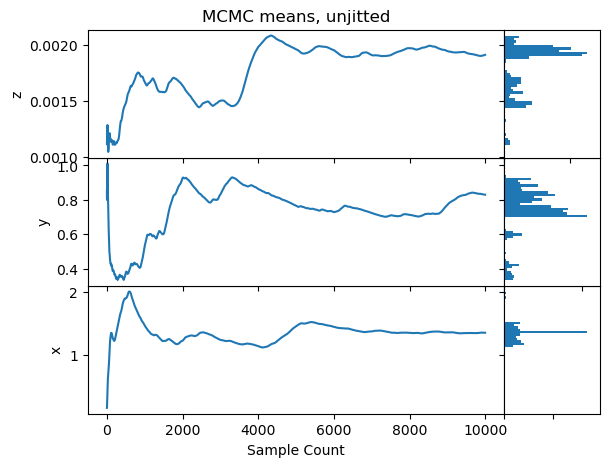

In [5]:
# Visualise results, unjitted.
traceplots(abQ_samples, xnames = ['x', 'y', 'z'], title = 'MCMC samples, unjitted')
traceplots(abQ_means, xnames = ['x', 'y', 'z'], title = 'MCMC means, unjitted')

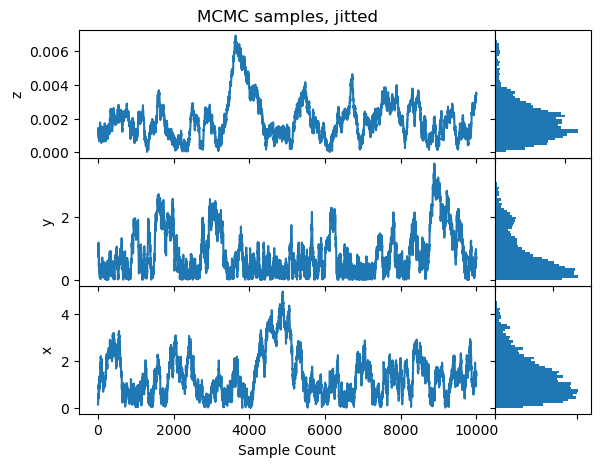

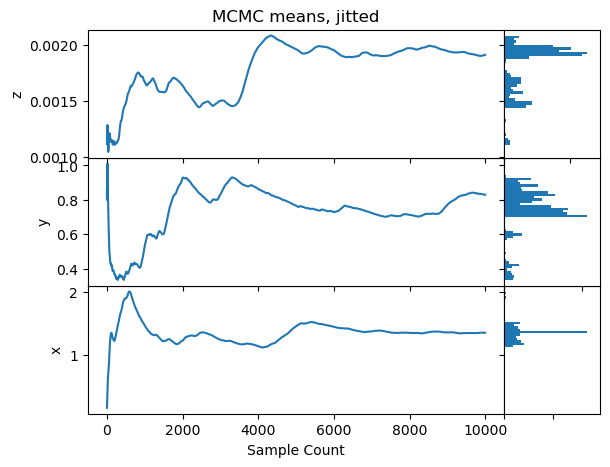

In [6]:
# Visualise results, jitted.
traceplots(abQ_samples_jit, xnames = ['x', 'y', 'z'], title = 'MCMC samples, jitted')
traceplots(abQ_means_jit, xnames = ['x', 'y', 'z'], title = 'MCMC means, jitted')

Inferred means: x = 1.35, y = 0.83, z = 0.0.


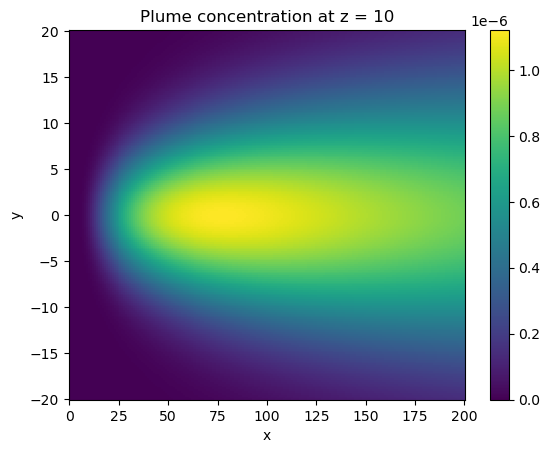

In [7]:
# Plot slices of the plume at set Z values using the mean values of the parameters.
# Jitted values adopted.

abQ_mean = abQ_means_jit[-1]
x = np.linspace(0.1, 200, 201)
y = np.linspace(-20, 20, 201)
#z = np.linspace(0, 400, 201)
X,Y = np.meshgrid(x, y)
Z = 10
C = C_func(X, Y, Z, wind_speed, abQ_mean[0], abQ_mean[1], abQ_mean[2], H)
plt.pcolor(X, Y, C, shading = 'auto')
plt.colorbar()
plt.title('Plume concentration at z = ' + str(Z))
plt.xlabel('x')
plt.ylabel('y')
print('Inferred means: x = ', round(abQ_mean[0], 2), ', y = ', round(abQ_mean[1], 2), ', z = ', round(abQ_mean[2], 2), '.', sep = '')

del(x)
del(y)

In [8]:
# Calculate the RMSE of this new model based on the data.
def RMSE_func(abQ, u, H, data):

    # Gaussian Plume Model for concentration.

    # Initialisations.
    negysqr = -data[:,2]**2            # Column 2 holds "y" values.
    zdownsqr = -(data[:,3] - H)**2     # Column 3 holds "z" values.
    zupsqr = -(data[:,3] + H)**2
    piu = np.pi * u                    # Saved as np.float64.

    # Column 1 holds "x" values.
    precalc1 = 2 * abQ[0] * data[:,1] ** abQ[1]
    # Column 0 holds "Concentration" values.
    precalc2 = (abQ[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data[:,0])**2

    # print(np.max(np.sqrt(precalc2)))

    RMSE = np.sqrt(sum(precalc2) / data.shape[0])
    print(' RMSE = ' + str(RMSE))
    return RMSE


RMSE = RMSE_func(abQ_mean, wind_speed, H, testing_data)

data_range = np.max(testing_data[:,0]) - np.min(testing_data[:,0])
print('Range = ' + str(data_range))

## saving_samples = pd.DataFrame({'a':abQ_samples[:,0],'b':abQ_samples[:,1],'Q':abQ_samples[:,2]})
# saving_samples = pd.DataFrame(abQ_samples,columns=['a','b','Q'])
# saving_samples.to_csv('samples.csv')

 RMSE = 0.0007037312614230802
Range = 0.010483296071400004


In [9]:
# Print the values of a, b and Q.
def print_vals(abQ_samples):

    abQ_samples = np.array(abQ_samples)
    vals = ['a','b','Q']
    for i in range(abQ_samples.shape[1]):
        print(vals[i] + ' = ' + str(np.mean(abQ_samples[:,i])) + ' +/- ' + str(np.std(abQ_samples[:,i])))

# Unjitted values.
print("Unjitted values:")
print_vals(abQ_samples)
print("")
# Jitted values.
print("Jitted values:")
print_vals(abQ_samples_jit)


Unjitted values:
a = 1.3526100665484972 +/- 0.9226544175250255
b = 0.8299748739402206 +/- 0.7151865947690448
Q = 0.0019090105501516196 +/- 0.0011856087445453367

Jitted values:
a = 1.3526100665484972 +/- 0.9226544175250255
b = 0.8299748739402206 +/- 0.7151865947690448
Q = 0.0019090105501516196 +/- 0.0011856087445453367
